In [64]:
import pandas as pd
import os
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
import math

In [65]:
from fair import *
from fair.scripts.data_retrieval import *

In [66]:
def get_ssp_emissions(ssp):
        #this returns emissions for most gases in a specific ssp
        emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1850:2200]
        ## rebase emission-driven forcings & species with natural emissions included in RCMIP to zero @ 1850
        rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
        emms.loc[:,rebase_species] -= emms.loc[1850,rebase_species]
        return emms

In [67]:
colors=['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # i think color blind friendly

# 1. Data

In [68]:
gas_2=['ch4','co2','n2o']
conversion=[10**(-3) /28, 10**(-6) * 12/44, 10**(-3)/265]#FaIR units

## 1.1 Reisinger data

In [69]:
NZ_historical=pd.read_excel("emissions_data\\Reisinger_NZ historical emissions.xlsx",index_col=0)
NZ_animal=pd.read_excel("emissions_data\\Reisinger_NZ reconstructed ag CH4 emissions.xlsx",index_col=0)
#everything is in ktCO2
time=np.arange(1990,2021)

## 1.2 Inventory data

In [70]:
def inv_data_2(sector):
    for (i,gas) in enumerate(gas_2):
        path="emissions_data\\inventory_data\\"+sector+'-'+gas+'.csv'
        df=pd.read_csv(path,index_col=0,nrows=31,header=0)
        if isinstance(df.loc[1990,'Emissions (kt CO₂-e)'], float)==False:
            df=df.applymap(lambda x: x.replace('+', ''))
            df=df.applymap(lambda x: x.replace(',', ''))
            df=df.astype(float)
        df=df.multiply(conversion[i])
        if i==0:
            df_big=df
        else:
            df_big=pd.concat([df_big,df],axis=1)
    df_big.columns=gases
    return df_big

In [71]:
gases=['methane','carbon_dioxide','nitrous_oxide']
agriculture_inv=inv_data_2('agriculture')
industry_inv=inv_data_2('industry')
waste_inv=inv_data_2('waste')
energy_inv=inv_data_2('energy')
sectors_inv=[agriculture_inv,industry_inv,waste_inv,energy_inv]

In [72]:
sector_ems_inv=[agriculture_inv,industry_inv,waste_inv,energy_inv]
total_ems_inv={}
total_ems_dict_inv={key: np.zeros(31) for key in gases}
for sector in sector_ems_inv:
    for gas in gases:
        total_ems_dict_inv[gas]+=sector.loc[1990:2020,gas].values
total_ems_inv=pd.DataFrame(total_ems_dict_inv,index=np.arange(1990,2021))

Text(0.5, 0.98, 'Total NZ emissions')

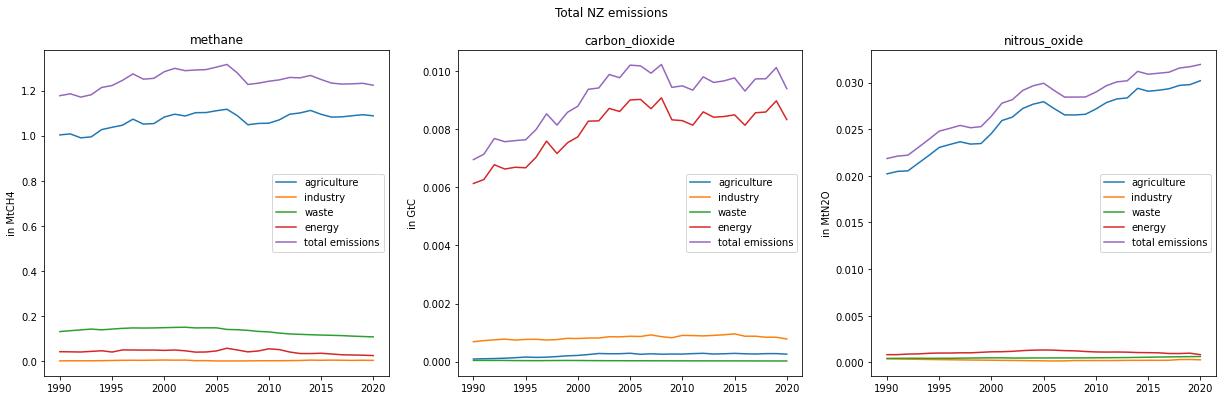

In [73]:
all_ems_inv=[agriculture_inv,industry_inv,waste_inv,energy_inv,total_ems_inv]
labels=['agriculture','industry','waste','energy','total emissions']

y_labels=['in MtCH4','in GtC','in MtN2O']
plt.figure(figsize=(21,6),facecolor='white')

for (i,gas) in enumerate(gases):
    plt.subplot(1,3,i+1)
    for (j,sector) in enumerate(all_ems_inv):
        plt.plot(sector.loc[:,gas],label=labels[j])
    plt.title(gas)
    plt.legend()
    plt.ylabel(y_labels[i])
plt.suptitle('Total NZ emissions')

## 1.3 PRIMAP data

In [74]:
# OLD version
# # Primap data
# columns=['Energy','Industrial Processes','Waste','Other','Agriculture']
# NZ_ch4 = pd.read_csv('https://www.pik-potsdam.de/paris-reality-check/primap-hist/data/HISTCR_NZL_CH4_Mt.csv',index_col=0,header=0,names=columns)
# NZ_co2=pd.read_csv('https://www.pik-potsdam.de/paris-reality-check/primap-hist/data/HISTCR_NZL_CO2_Mt.csv',index_col=0,header=0,names=columns)
# NZ_n2o=pd.read_csv('https://www.pik-potsdam.de/paris-reality-check/primap-hist/data/HISTCR_NZL_N2O_Mt.csv',index_col=0,header=0,names=columns)
# NZ_em=[NZ_ch4,NZ_co2,NZ_n2o]  

In [75]:
#Primap data
columns=['Energy','Industrial Processes','Waste','Other','Agriculture']
NZ_ch4 = pd.read_csv('emissions_data\\HISTCR_NZL_CH4_Mt.csv',index_col=0,header=0,names=columns)
NZ_co2=pd.read_csv('emissions_data\\HISTCR_NZL_CO2_Mt.csv',index_col=0,header=0,names=columns)
NZ_n2o=pd.read_csv('emissions_data\\HISTCR_NZL_N2O_Mt.csv',index_col=0,header=0,names=columns)
NZ_em=[NZ_ch4,NZ_co2,NZ_n2o]  

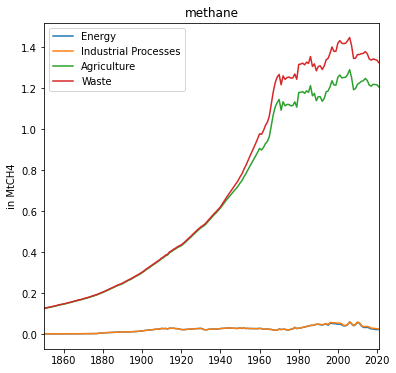

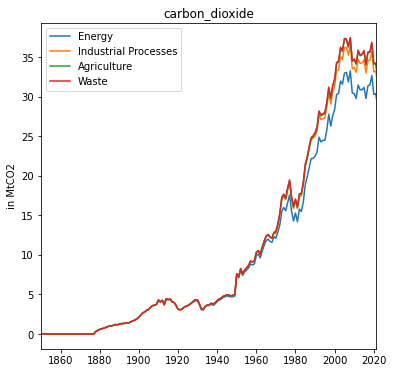

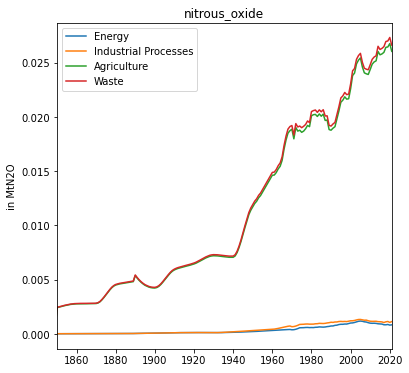

In [76]:
sectors=['Energy','Industrial Processes','Agriculture','Waste']
gases=['methane','carbon_dioxide','nitrous_oxide']
y_labels=['in MtCH4','in MtCO2','in MtN2O']
for i,em in enumerate(NZ_em):
    em[sectors].plot(kind='line',stacked=True,figsize=(6,6))
    plt.xlim(1850,2021)
    plt.title(gases[i])
    plt.ylabel(y_labels[i])
    plt.show()

In [77]:
em

,Energy,Industrial Processes,Waste,Other,Agriculture
1750,0.000000,0.000000,0.000006,3.920000e-24,0.000002
1751,0.000000,0.000000,0.000006,4.130000e-10,0.000002
1752,0.000000,0.000000,0.000006,8.260000e-10,0.000002
1753,0.000000,0.000000,0.000007,1.240000e-09,0.000002
1754,0.000000,0.000000,0.000007,1.650000e-09,0.000002
...,...,...,...,...,...
2018,0.000847,0.000273,0.000536,1.510000e-07,0.025300
2019,0.000875,0.000277,0.000552,1.720000e-07,0.025300
2020,0.000817,0.000248,0.000562,1.680000e-07,0.025700
2021,0.000843,0.000300,0.000567,1.520000e-07,0.024900


In [78]:
#making the df
conversion=[1,12/44 *10**(-3),1] #converting to FaIR units
def dataframe_sector(sector):
    data={}
    for (i,gas) in enumerate(gases):
        em=NZ_em[i]
        data[gas]=em.loc[:,sector]*conversion[i]
    return pd.DataFrame(data,index=np.arange(1850,2021))

In [79]:
agriculture=dataframe_sector('Agriculture')
waste=dataframe_sector('Waste')
industry=dataframe_sector('Industrial Processes')
energy=dataframe_sector('Energy')
sectors=[agriculture,industry,waste,energy]

In [80]:
agriculture.name='agriculture'
waste.name='waste'
industry.name='industry'
energy.name='energy'

In [81]:
def fill_2020(sector_inv,sector): 
    #add 2020 value using inventory data
    #method: use the same difference ratio between 2019 and 2020 inventory data and apply that to 2019 PRIMAP data
    dict_2020_dif_ratio={}
    for gas in gases:
        if sector_inv.loc[2019,gas]==0:
            sector.loc[2020,gas]=sector.loc[2019,gas]
        else:
            sector.loc[2020,gas]=(1+(sector_inv.loc[2020,gas]-sector_inv.loc[2019,gas])/sector_inv.loc[2019,gas]) *sector.loc[2019,gas]
for i in range(4):
    fill_2020(sectors_inv[i],sectors[i])

Text(0.5, 0.98, 'Comparing emissions from the different datasets')

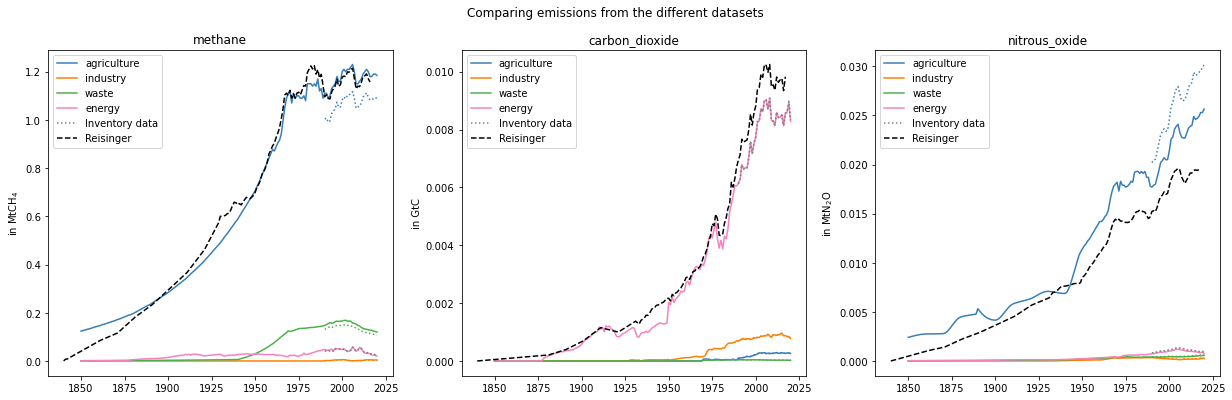

In [82]:
plt.figure(figsize=(21,6),facecolor='white')
y_labels=['in MtCH$_4$','in GtC','in MtN$_2$O']
for (i,gas) in enumerate(gases):
    plt.subplot(1,3,i+1)
    for (j,sector) in enumerate(sectors):
        plt.plot(sector.loc[:,gas],label=labels[j],color=colors[j])
        plt.plot(sectors_inv[j].loc[:,gas],linestyle=':',color=colors[j])
    plt.plot(sectors_inv[j].loc[:,gas],linestyle=':',color='gray',label='Inventory data')
    plt.title(gas)
    plt.legend()
    plt.ylabel(y_labels[i])
    
plt.subplot(1,3,1)
plt.plot(NZ_historical.loc[:,'CH4 (agriculture)'],label='Reisinger',color='black',linestyle='--')
plt.legend()

plt.subplot(1,3,2)
plt.plot(NZ_historical.loc[:,'CO2 (fossil)'],label='Reisinger',color='black',linestyle='--')
plt.legend()

plt.subplot(1,3,3)
plt.plot(NZ_historical.loc[:,'N2O'],label='Reisinger',color='black',linestyle='--')
plt.legend()

plt.suptitle('Comparing emissions from the different datasets')


## 1.4 Scaling the data

In [83]:
sector_names=['agriculture','industry','waste','energy']

In [84]:
#scale the data by taking the ratio of the mean of the inventory data and PRIMAP data between 1990 and 2020
for i,sector in enumerate(sector_names):
    for gas in gases:
        sectors[i].loc[:,gas]=sectors[i].loc[:,gas]*sectors_inv[i].loc[1990:2020,gas].mean()/sectors[i].loc[1990:2020,gas].mean()

Text(0.5, 0.98, 'Scaled emissions')

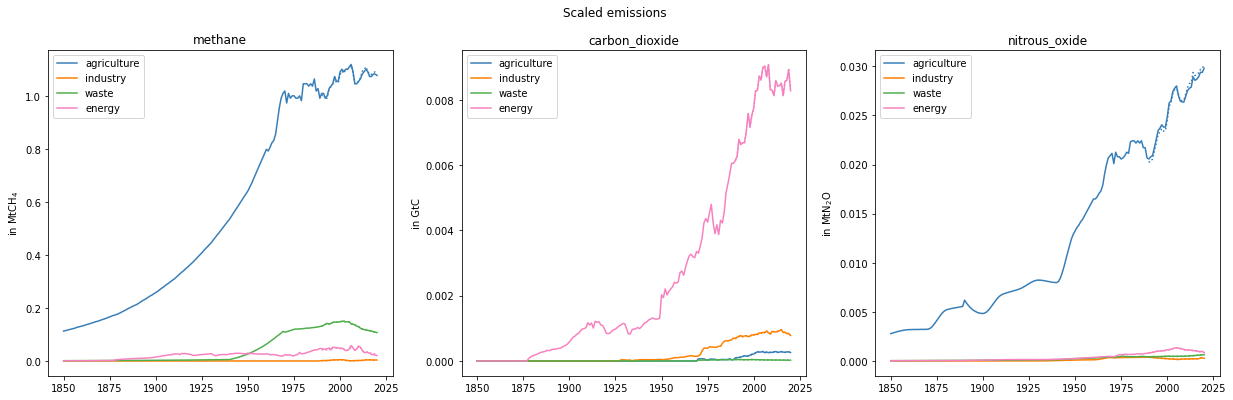

In [85]:
plt.figure(figsize=(21,6),facecolor='white')
for (i,gas) in enumerate(gases):
    plt.subplot(1,3,i+1)
    for (j,sector) in enumerate(sectors):
        plt.plot(sector.loc[:,gas],label=labels[j],color=colors[j])
        plt.plot(sectors_inv[j].loc[:,gas],linestyle=':',color=colors[j])
    plt.title(gas)
    plt.legend()
    plt.ylabel(y_labels[i])

plt.suptitle('Scaled emissions')


In [86]:
# Initialize an empty DataFrame to store the result
result = pd.DataFrame(columns=sectors[0].columns)

# Sum the columns with the same name across the DataFrames
for col in sectors[0].columns:
    result[col] = sectors[0][col] + sectors[1][col] + sectors[2][col] + sectors[3][col]

In [87]:
result

,methane,carbon_dioxide,nitrous_oxide
1850,0.114589,0.000000,0.002845
1851,0.116448,0.000000,0.002904
1852,0.118306,0.000000,0.002964
1853,0.120167,0.000000,0.003023
1854,0.122026,0.000000,0.003070
...,...,...,...
2016,1.223512,0.009307,0.030521
2017,1.217365,0.009734,0.030708
2018,1.222795,0.009742,0.031258
2019,1.219553,0.010069,0.031312
